In [1]:
import os
import time
import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import pyabf
import utils

%load_ext autoreload
%autoreload 2

In [2]:
human18_meta = pd.read_csv('./data/raw/Metadata/Human18_Metadatav2.csv')
human18_meta.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
human18_meta.shape

(139, 18)

In [4]:
human18_meta.head()

,ABF File,Data Type,Exp. Date,Case #,Cell #,Cell Layer,Stim Type,Threshold,Gain Value,ZD,Hold,Unnamed: 12,Gain,Offset,Response Channel,Command Channel,RMP,Stimulus type
0,18320001,Human,March_20_2018,First,C1,L23,Firing,n.a,n.a,n.a,n.a,NaN,1.0,-20.0,Iclamp(mV),Current_in(pA),-70.0,Ramp
1,18320005,Human,March_20_2018,First,C1,L23,Firing,n.a,n.a,n.a,n.a,NaN,1.0,-20.0,Iclamp(mV),Current_in(pA),-70.5,Long_Square
2,18320015,Human,March_20_2018,First,C2,L23,Firing,n.a,n.a,n.a,n.a,NaN,1.0,-20.0,Iclamp(mV),Current_in(pA),-68.1,Long_Square
3,18320019,Human,March_20_2018,First,C3,L23,Firing,n.a,n.a,n.a,n.a,NaN,1.0,-27.0,Iclamp(mV),Current_in(pA),-71.3,Ramp
4,18320021,Human,March_20_2018,First,C3,L23,Firing,n.a,n.a,n.a,n.a,NaN,1.0,-27.0,Iclamp(mV),Current_in(pA),-71.3,Long_Square


In [5]:
human18_meta['Stim Type'].value_counts()

Gain      92
Firing    42
n.a        5
Name: Stim Type, dtype: int64

In [6]:
human18_meta['Stimulus type'].value_counts()

Long_Square    22
Ramp           20
Name: Stimulus type, dtype: int64

In [7]:
human18_meta.drop_duplicates(subset='ABF File', inplace=True)

In [8]:
human18_meta.iloc[0]

ABF File                  18320001
Data Type                    Human
Exp. Date            March_20_2018
Case #                       First
Cell #                          C1
Cell Layer                     L23
Stim Type                   Firing
Threshold                      n.a
Gain Value                     n.a
ZD                             n.a
Hold                           n.a
Unnamed: 12                    NaN
Gain                           1.0
Offset                       -20.0
Response Channel        Iclamp(mV)
Command Channel     Current_in(pA)
RMP                          -70.0
Stimulus type                 Ramp
Name: 0, dtype: object

In [9]:
all_meta = pd.read_csv('./data/processed/meta/human_meta_cleaned.csv')

In [10]:
all_meta.iloc[0]

ABF File                             13n05011
Data Type                               Human
expt_date                          2013-11-05
layer_name                                 L5
RMP                                -54.937742
subject_id                        X2013.11.05
sex                                         M
age                                        57
seizure_duration_years                     45
resection_location                  Right-ATL
drugs                           LSC, CZP, CBZ
Cell #                                      1
ZD status                                 n.a
internal_soln             Potassium gluconate
external_soln                            aCSF
aggregated_cell_layer                      L5
diagnosis_Epilepsy                       True
diagnosis_Tumor                         False
Name: 0, dtype: object

In [11]:
human18_meta = human18_meta.merge(all_meta.loc[:, ['ABF File', 'subject_id', 'sex', 'age', 'seizure_duration_years', 
                                                   'diagnosis_Epilepsy', 'diagnosis_Tumor', 'resection_location', 'drugs', 'internal_soln',
                                                   'external_soln']], on='ABF File')

## Identify files to be converted
- ABF files from human2018
- need metadata to determine which files are testing intrinsic properties
- extract ABF version info, time of creation and comments from the ABF file

In [12]:
human2018_abf_dir = Path("./data/raw/recordings/Human tissue/Human tissue-White noise_2018/")
human2018_file_info = utils.summary_df(human2018_abf_dir)

In [13]:
human2018_file_info.shape

(174, 2)

In [14]:
%%time
def parse_timestamp(abf_path):
    abf = pyabf.ABF(abf_path)
    return datetime.datetime.strptime(abf.abfDateTimeString, "%Y-%m-%dT%H:%M:%S.%f")

def extract_abf_version(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.abfVersionString

def extract_abf_comments(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.tagComments

def check_protocolpath_for_experimenter(abf_path):
    abf = pyabf.ABF(abf_path)
    if 'Homeira' in abf.protocolPath:
        return 'Homeira'
    elif 'Lihua' in abf.protocolPath:
        return 'Lihua'
    else:
        #print(abf.protocolPath)
        return None

#human2018_file_info['timestamp'] = human2018_file_info.path.apply(parse_timestamp)
#human2018_file_info['abf_version'] = human2018_file_info.path.apply(extract_abf_version)
#human2018_file_info['abf_comments'] = human2018_file_info.path.apply(extract_abf_comments)
human2018_file_info['experimenter'] = human2018_file_info.path.apply(check_protocolpath_for_experimenter)

# add this column to merge with provided metadata
human2018_file_info['file_id'] = human2018_file_info.file_name.apply(lambda x: Path(x).stem) 

CPU times: user 734 ms, sys: 337 ms, total: 1.07 s
Wall time: 1.28 s


In [15]:
human2018_file_info.experimenter.value_counts()

Homeira    77
Name: experimenter, dtype: int64

In [16]:
human2018_file_info.file_id.nunique()

162

In [17]:
human2018_file_info.drop_duplicates(subset='file_id', keep='first', inplace=True)

In [18]:
human2018_file_info.shape

(162, 4)

In [19]:
merged_meta = human18_meta.merge(human2018_file_info, left_on='ABF File', right_on='file_id' , how='left').drop('ABF File', axis=1)

In [20]:
merged_meta.shape

(18, 31)

## Extract metadata required for conversion process

In [21]:
# sweep through all listed abf files and extract all relevant metadata required to parse raw data
results_list = []
for i, row in merged_meta.iterrows():
    
    resp_chan = 0
    stim_chan = 0
    stim_info_dict = {}
    
    abf = pyabf.ABF(row.path)
    num_sweeps = abf.sweepCount
    abf_tag = abf.tagComments
    if abf_tag:
        abf_tag = abf_tag[0]
    else:
        abf_tag = None
    print(row.path)
    #print(abf_tag)
    print(f'len Channellist: {len(abf.channelList)}')
    
    if len(abf.channelList) == 3:
        #print(abf_file)
        stim_chan = 2
        abf.setSweep(0, channel=stim_chan)
        stim_vec = abf.sweepY
        
        resp_chan = 1
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)
        
        stim_gain = 10
        valid_stim = True
        stim_temp_dict = {'stim_chan' : stim_chan, 'stim_gain' : stim_gain, 'stim_path' : row.path, 
                          'valid_stim' : valid_stim}
        stim_dict = utils.get_stim_info(abf, stim_channel_num = stim_chan, stim_gain = stim_gain, stim_name = 'sweepY')
        stim_dict.update(stim_temp_dict)
        stim_name = 'sweepY'   
        print(stim_dict)
        
    elif len(abf.channelList) == 4:

        stim_chan = 3
        abf.setSweep(0, channel=stim_chan)
        stim_vec = abf.sweepY
        
        resp_chan = 2
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)
        
        stim_gain = .2
        valid_stim = True
        stim_temp_dict = {'stim_chan' : stim_chan, 'stim_gain' : stim_gain, 'stim_path' : row.path, 'valid_stim' : valid_stim}
        stim_dict = utils.get_stim_info(abf, stim_channel_num = stim_chan, stim_gain = stim_gain, stim_name = 'sweepY')
        stim_dict.update(stim_temp_dict)
        stim_name = 'sweepY'   
        print(f'RESP_SAMPLING_RATE: {resp_sampling_rate}')
    else:
        # figure out response channel
        abf.setSweep(0, channel=resp_chan)
        resp_vec = abf.sweepY
        resp_sampling_rate = int(round(1/(abf.sweepX[2] - abf.sweepX[1]))) # manually calculate the sampling rate

        # try to figure out gain on response channel by comparing to RMP
        #(best_gain, rmp_abs_error) = guess_response_gain(resp_vec, cell_rmp, resp_offset)
        (best_gain, rmp_abs_error) = utils.guess_response_gain(resp_vec, row.RMP, row.Offset)

        stim_name = 'sweepY'
        
        cell_meta_df = None
        try:
            stim_dict = utils.get_stim_dict2(row, cell_meta_df, stim_name)
        except AttributeError as e:
            print(e)
        
        # if in the odd case the number of sweeps doesn't match between resp vs stim file, then make them match
    print(f'num_sweeps: {num_sweeps}')
    print(f'stim_dict: {stim_dict}')
    if num_sweeps != stim_dict['num_sweeps']:
        #print(abf_file)
        stim_dict['num_sweeps'] = num_sweeps
        stim_dict['stim_amp_vec'] = stim_dict['stim_amp_vec'][0:num_sweeps]
        
    ret_dict = {'cell_id' : row.file_id, 'resp_chan' : resp_chan, 
                'resp_gain' : best_gain, 'rmp_error' : rmp_abs_error, 'abf_tag' : abf_tag,
                'rmp_val' : row.RMP, 'resp_offset' : row.Offset,
                'abf_version' : abf.abfVersionString, 'resp_sampling_rate' : resp_sampling_rate, 'stim_name' : stim_name, 
               'file_time' : abf.abfDateTime}
    #ret_dict = dict(ret_dict.items() + stim_info_dict.items())
    ret_dict.update(stim_dict)
    #print(ret_dict)

    results_list.append(ret_dict)
    print('--'*50)

data/raw/recordings/Human tissue/Human tissue-White noise_2018/March_20_2018/First case/C1_L23/Firing/18320005.abf
len Channellist: 2
num_sweeps: 14
stim_dict: {'stim_chan': 1, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/March_20_2018/First case/C1_L23/Firing/18320005.abf', 'valid_stim': True, 'stim_amp_vec': array([-551., -450., -353., ...,  550.,  649.,  748.]), 'stim_duration': 0.1496, 'stim_start_time': 0.0374, 'stim_end_time': 1.0362, 'num_sweeps': 14, 'stim_sampling_rate': 10000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Human tissue/Human tissue-White noise_2018/March_20_2018/First case/C3_L23/Firing/18320021.abf
len Channellist: 2
num_sweeps: 12
stim_dict: {'stim_chan': 1, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/March_20_2018/First case/C3_L23/Firing/18320021.abf', 'valid_stim': True, 'stim_amp

num_sweeps: 16
stim_dict: {'stim_chan': 1, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/October_ 22_2018/C1_L23/Firing/18o22001.abf', 'valid_stim': True, 'stim_amp_vec': array([-598., -499., -399., ...,  699.,  801.,  902.]), 'stim_duration': 0.1838, 'stim_start_time': 0.0378, 'stim_end_time': 1.0370000000000001, 'num_sweeps': 16, 'stim_sampling_rate': 10000}
----------------------------------------------------------------------------------------------------
data/raw/recordings/Human tissue/Human tissue-White noise_2018/October_ 22_2018/C2_L23/Firing/18o22010.abf
len Channellist: 2
num_sweeps: 15
stim_dict: {'stim_chan': 1, 'stim_gain': 1000, 'stim_path': 'data/raw/recordings/Human tissue/Human tissue-White noise_2018/October_ 22_2018/C2_L23/Firing/18o22010.abf', 'valid_stim': True, 'stim_amp_vec': array([-598., -500., -399., ...,  601.,  700.,  803.]), 'stim_duration': 0.0865, 'stim_start_time': 0.038200000000000005, 'stim_end_time': 

In [22]:
extracted_meta = pd.DataFrame(results_list)

In [23]:
extracted_meta.shape

(18, 21)

In [24]:
all_meta = merged_meta.merge(extracted_meta, left_on='file_id', right_on='cell_id', how='left').drop('cell_id', axis=1)

In [25]:
all_meta.iloc[0]

Data Type                                                             Human
Exp. Date                                                     March_20_2018
Case #                                                                First
Cell #                                                                   C1
Cell Layer                                                              L23
Stim Type                                                            Firing
Threshold                                                               n.a
Gain Value                                                              n.a
ZD                                                                      n.a
Hold                                                                    n.a
Unnamed: 12                                                             NaN
Gain                                                                    1.0
Offset                                                                -20.0
Response Cha

In [26]:
# after visual QC, determined stim gains for this dataset need to be set to 400
all_meta.stim_gain = 400

In [27]:
meta_path = Path('./data/processed/meta')
meta_path.mkdir(exist_ok=True)
all_meta.to_csv(meta_path / 'h2018_meta.csv')

## Convert

In [28]:
output_dir = Path("data/processed/recordings/human/h2018")
output_dir.mkdir(exist_ok=True, parents=True)

In [29]:
from x_to_nwb import ABF2Converter
from x_to_nwb import ABF1Converter

In [30]:
all_meta[all_meta['Stimulus type'] == 'Long_Square'].iloc[0]

Data Type                                                             Human
Exp. Date                                                     March_20_2018
Case #                                                                First
Cell #                                                                   C1
Cell Layer                                                              L23
Stim Type                                                            Firing
Threshold                                                               n.a
Gain Value                                                              n.a
ZD                                                                      n.a
Hold                                                                    n.a
Unnamed: 12                                                             NaN
Gain                                                                    1.0
Offset                                                                -20.0
Response Cha

In [31]:
%%time
errors = []

for i, file_info in all_meta[all_meta['Stimulus type'] == 'Long_Square'].iterrows():
    print(file_info)
    try:
        abf = pyabf.ABF(file_info.path) # abf file to be converted
        file_stem = file_info.file_id # file stem with no file type
        
        # figure out if stimulus is on dac or adc channels
        if file_info.stim_name == 'sweepC': 
            stim_chan = abf.dacNames[file_info.stim_chan] 
        else: #if stim_name is sweepY
            stim_chan = abf.adcNames[file_info.stim_chan] 
        
        resp_chan = abf.adcNames[file_info.resp_chan] # response seems always to be in adc channels
        
        # this should be populated with metadata from homeira!
        meta = {
            'Subject': {
                'age': f'P{file_info.age}Y',
                'description': f'{file_info.abf_tag}',
                'species': 'Homo sapiens',
                #'subject_id': f'Donor-{file_info["Exp. Date"]}-{file_info["Case #"]}-{file_info["Cell #"]}'
                'subject_id': f'{file_info["subject_id"]}'
            }
        }

        
        output_path = output_dir / f'{file_stem}.nwb'
        
        if file_info.abf_version == '2.6.0.0': # if abf v2 file
            # i didn't use gain here because none of my abf v2 files needed a gain - feel free to add one though
            nwb = ABF2Converter.ABF2Converter(file_info.path, 
                                              str(output_path), 
                                              includeChannelList=[resp_chan], 
                                              stimulus_name=stim_chan, 
                                              metadata=meta)
        
        else: # if abf 1 file
            nwb = ABF1Converter.ABF1Converter(inputPath = file_info.path, 
                                                    outputFilePath = str(output_path), 
                                                    acquisitionChannelName = resp_chan, 
                                                    stimulusChannelName = stim_chan,
                                                    metadata=meta, 
                                                    responseGain = file_info.resp_gain, # gain on response channel
                                                    stimulusGain = file_info.stim_gain, # gain on stimulus channel
                                                    responseOffset = file_info.resp_offset, # voltage offset on resp channel
                                                    )
            nwb.convert()
        print(nwb)
        print("NWB Conversion complete for " + file_stem +'.nwb\n')
        print('--'*50)
        
    except (ValueError, IndexError, TypeError, KeyError, UnicodeDecodeError, AttributeError) as e:
        print('**'*50)
        print(f'Error: {e} \n {file_info.path} \n')
        errors.append((e, file_info.file_id, file_info.path))

Data Type                                                             Human
Exp. Date                                                     March_20_2018
Case #                                                                First
Cell #                                                                   C1
Cell Layer                                                              L23
Stim Type                                                            Firing
Threshold                                                               n.a
Gain Value                                                              n.a
ZD                                                                      n.a
Hold                                                                    n.a
Unnamed: 12                                                             NaN
Gain                                                                    1.0
Offset                                                                -20.0
Response Cha

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/pynwb/file.py:753: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")


Successfully converted to data/processed/recordings/human/h2018/18320005.nwb.
NWB Conversion complete for 18320005.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                             Human
Exp. Date                                                     March_20_2018
Case #                                                                First
Cell #                                                                   C3
Cell Layer                                                              L23
Stim Type                                                            Firing
Threshold                                                               n.a
Gain Value                                                              n.a
ZD                                                                      n.a
Hold                                                                    n.a
Unnamed: 12        

Successfully converted to data/processed/recordings/human/h2018/18320031.nwb.
NWB Conversion complete for 18320031.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                             Human
Exp. Date                                                     April_26_2018
Case #                                                                  n.a
Cell #                                                                   C1
Cell Layer                                                              L23
Stim Type                                                            Firing
Threshold                                                               n.a
Gain Value                                                              n.a
ZD                                                                      n.a
Hold                                                                    n.a
Unnamed: 12        

Successfully converted to data/processed/recordings/human/h2018/18426017.nwb.
NWB Conversion complete for 18426017.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                             Human
Exp. Date                                                       Feb_01_2018
Case #                                                                  n.a
Cell #                                                                   C1
Cell Layer                                                               L5
Stim Type                                                            Firing
Threshold                                                               n.a
Gain Value                                                              n.a
ZD                                                                      n.a
Hold                                                                    n.a
Unnamed: 12        

Successfully converted to data/processed/recordings/human/h2018/18201011.nwb.
NWB Conversion complete for 18201011.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                             Human
Exp. Date                                                       Feb_20_2018
Case #                                                                  n.a
Cell #                                                                   C3
Cell Layer                                                              L23
Stim Type                                                            Firing
Threshold                                                               n.a
Gain Value                                                              n.a
ZD                                                                      n.a
Hold                                                                    n.a
Unnamed: 12        

Successfully converted to data/processed/recordings/human/h2018/18220019.nwb.
NWB Conversion complete for 18220019.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                             Human
Exp. Date                                                       Jan_29_2018
Case #                                                                  n.a
Cell #                                                                   C2
Cell Layer                                                               L5
Stim Type                                                            Firing
Threshold                                                               n.a
Gain Value                                                              n.a
ZD                                                                      n.a
Hold                                                                    n.a
Unnamed: 12        

Successfully converted to data/processed/recordings/human/h2018/18129009.nwb.
NWB Conversion complete for 18129009.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                             Human
Exp. Date                                                     March_29_2018
Case #                                                                  n.a
Cell #                                                                  C10
Cell Layer                                                              L23
Stim Type                                                            Firing
Threshold                                                               n.a
Gain Value                                                              n.a
ZD                                                                      n.a
Hold                                                                    n.a
Unnamed: 12        

Successfully converted to data/processed/recordings/human/h2018/18329062.nwb.
NWB Conversion complete for 18329062.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                             Human
Exp. Date                                                     March_29_2018
Case #                                                                  n.a
Cell #                                                                   C3
Cell Layer                                                              L23
Stim Type                                                            Firing
Threshold                                                               n.a
Gain Value                                                              n.a
ZD                                                                      n.a
Hold                                                                    n.a
Unnamed: 12        

Successfully converted to data/processed/recordings/human/h2018/18329044.nwb.
NWB Conversion complete for 18329044.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                             Human
Exp. Date                                                  October_ 22_2018
Case #                                                                  n.a
Cell #                                                                   C1
Cell Layer                                                              L23
Stim Type                                                            Firing
Threshold                                                               n.a
Gain Value                                                              n.a
ZD                                                                      n.a
Hold                                                                    n.a
Unnamed: 12        

Successfully converted to data/processed/recordings/human/h2018/18o22010.nwb.
NWB Conversion complete for 18o22010.nwb

----------------------------------------------------------------------------------------------------
Data Type                                                             Human
Exp. Date                                                  October_ 22_2018
Case #                                                                  n.a
Cell #                                                                   C3
Cell Layer                                                              L23
Stim Type                                                            Firing
Threshold                                                               n.a
Gain Value                                                              n.a
ZD                                                                      n.a
Hold                                                                    n.a
Unnamed: 12        

In [32]:
errors

[]

## Plot the converted nwb files

In [33]:
ontology_path = "./data/stim_ontology_new_Homeira.json"

In [34]:
nwb_files = utils.summary_df(path=Path('./data/processed/recordings/human/h2018/'), suffix='.nwb')

/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbephystest/lib/python3.8/site-packages/ipfx/stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
/Users/derek_howard/miniconda3/envs/nwbe

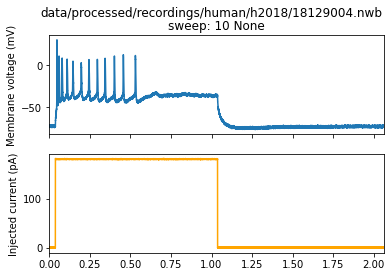

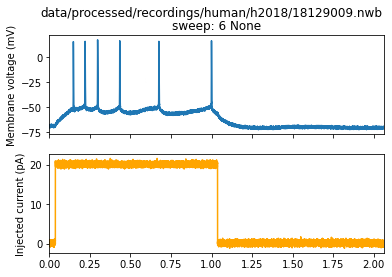

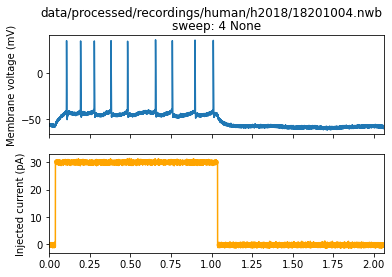

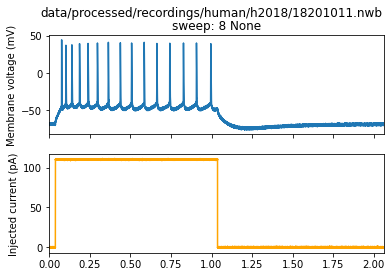

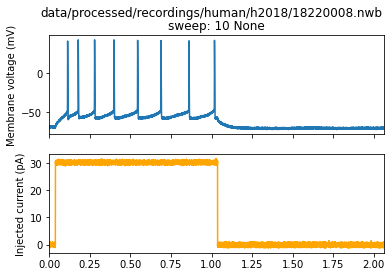

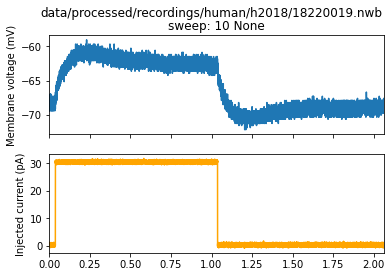

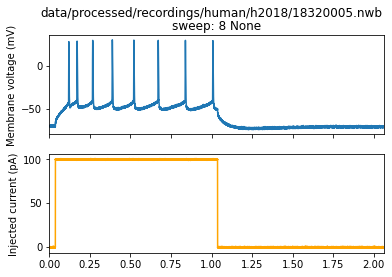

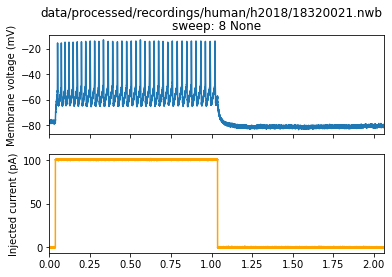

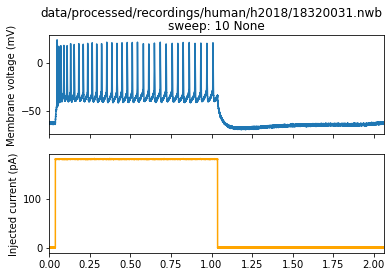

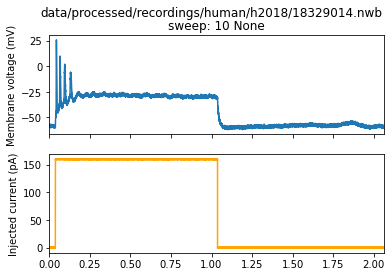

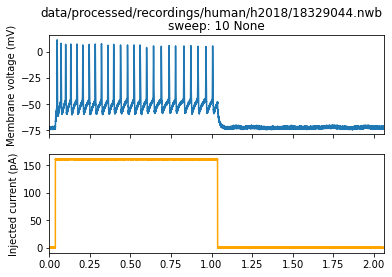

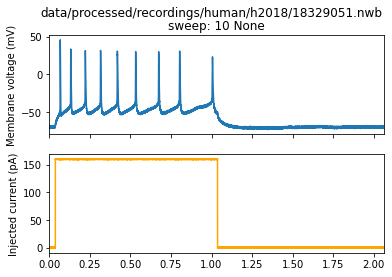

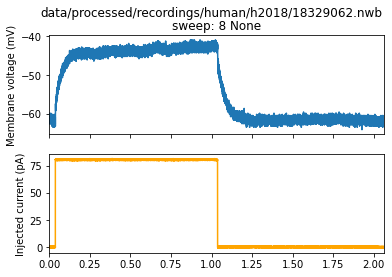

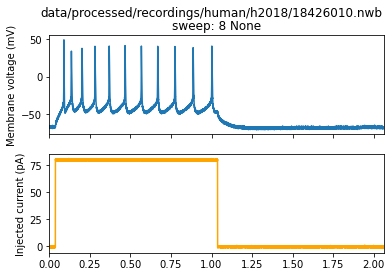

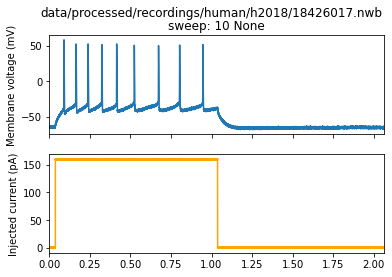

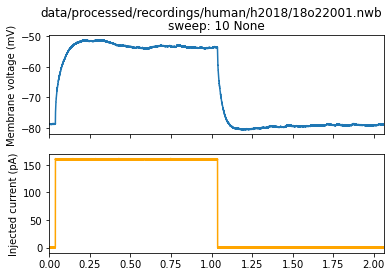

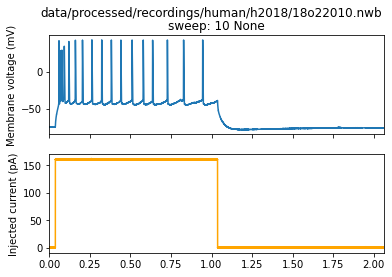

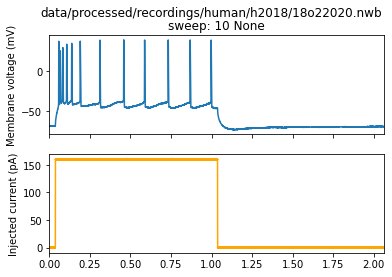

In [35]:
for i, row in nwb_files.sort_values('file_name').iterrows():
    utils.plot_nwb_sweep(file_name=row.path, ontology=ontology_path)

In [36]:
!dandi validate ./data/processed/recordings/human/h2018/

2022-01-26 11:19:55,224 [ WARNING] A newer version (0.35.0) of dandi/dandi-cli is available. You are using 0.34.1
2022-01-26 11:19:55,514 [    INFO] NumExpr defaulting to 8 threads.
2022-01-26 11:19:58,888 [    INFO] ./data/processed/recordings/human/h2018/18329051.nwb: ok
2022-01-26 11:20:01,103 [    INFO] ./data/processed/recordings/human/h2018/18329044.nwb: ok
2022-01-26 11:20:03,199 [    INFO] ./data/processed/recordings/human/h2018/18o22020.nwb: ok
2022-01-26 11:20:05,315 [    INFO] ./data/processed/recordings/human/h2018/18129004.nwb: ok
2022-01-26 11:20:07,217 [    INFO] ./data/processed/recordings/human/h2018/18426010.nwb: ok
2022-01-26 11:20:09,337 [    INFO] ./data/processed/recordings/human/h2018/18320005.nwb: ok
2022-01-26 11:20:11,353 [    INFO] ./data/processed/recordings/human/h2018/18426017.nwb: ok
2022-01-26 11:20:13,289 [    INFO] ./data/processed/recordings/human/h2018/18201011.nwb: ok
2022-01-26 11:20:15,225 [    INFO] ./data/processed/recordings/human/h2018/1822000